In [399]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
from scipy.signal import savgol_filter
import seaborn as sns
import ast
sns.set()

# Trajectories (obs, actions, penalty)

In [400]:
!ls ../data/a3c

a3c_trajectories_0.csv	a3c_trajectories_1.csv	a3c_trajectories_2.csv


In [401]:
path = "../results/2_new_NN_architecture/4_results_report/4_heterogeneous_goood/im_2/standby_0/gpu_10/"
path = "../data/"
COLUMN_NAMES = ["util_0", "power_0", "it_0", "cool_0",
                "util_1", "power_1", "it_1", "cool_1",
                "util_2", "power_2", "it_2", "cool_2",
                "action", "penalty"]
df = pd.read_csv(path+'a3c/a3c_trajectories_1.csv',
                 delimiter=";",
                 names=COLUMN_NAMES,)
df

,util_0,power_0,it_0,cool_0,util_1,power_1,it_1,cool_1,util_2,power_2,it_2,cool_2,action,penalty
0,-2.949946,-5.148372,-5.148372,-5.148372,-2.949946,-4.739408,-5.148372,-4.739408,-2.949946,-4.739408,-5.148372,-4.739408,edc_1,False
1,-2.949946,-5.148372,-5.148372,-5.148372,-2.949946,-4.739408,-5.148372,-4.739408,-2.949946,-4.739408,-5.148372,-4.739408,edc_1,False
2,-2.949946,-3.884206,-4.185629,-4.846950,-2.949946,-3.961413,-4.370378,-4.739408,-2.949946,-3.961413,-4.370378,-4.739408,edc_1,False
3,-2.949946,-3.884206,-4.185629,-4.846950,-2.725288,-3.912188,-4.308651,-4.751909,-2.949946,-3.961413,-4.370378,-4.739408,edc_1,False
4,-2.949946,-3.884206,-4.185629,-4.846950,-2.500629,-3.855959,-4.232293,-4.772039,-2.949946,-3.961413,-4.370378,-4.739408,edc_1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2412,-2.949946,-3.884206,-4.185629,-4.846950,1.992541,1.887226,1.655712,-4.916858,-2.500629,-3.184989,-3.454298,-4.879063,edc_1,False
2413,-2.949946,-3.884206,-4.185629,-4.846950,1.767883,1.852265,1.622033,-4.918141,-2.500629,-3.184989,-3.454298,-4.879063,edc_2,False
2414,-2.949946,-3.884206,-4.185629,-4.846950,1.880212,1.869740,1.638872,-4.917504,-2.500629,-3.184989,-3.454298,-4.879063,edc_1,False
2415,-2.949946,-3.884206,-4.185629,-4.846950,1.992541,1.887226,1.655712,-4.916858,-2.500629,-3.184989,-3.454298,-4.879063,edc_1,False


In [402]:
df.action.value_counts()

edc_1    2200
edc_2     211
edc_0       6
Name: action, dtype: int64

In [403]:
df.penalty.value_counts()

False    2417
Name: penalty, dtype: int64

In [404]:
interval = 100
for i in range(len(df)//interval):
    print(df.iloc[i*interval:(i+1)*interval]["action"].value_counts())

edc_1    88
edc_2    12
Name: action, dtype: int64
edc_1    93
edc_2     7
Name: action, dtype: int64
edc_1    92
edc_2     7
edc_0     1
Name: action, dtype: int64
edc_1    90
edc_2    10
Name: action, dtype: int64
edc_1    96
edc_2     4
Name: action, dtype: int64
edc_1    86
edc_2    14
Name: action, dtype: int64
edc_1    87
edc_2    13
Name: action, dtype: int64
edc_1    93
edc_2     6
edc_0     1
Name: action, dtype: int64
edc_1    92
edc_2     8
Name: action, dtype: int64
edc_1    88
edc_2    10
edc_0     2
Name: action, dtype: int64
edc_1    93
edc_2     7
Name: action, dtype: int64
edc_1    91
edc_2     8
edc_0     1
Name: action, dtype: int64
edc_1    94
edc_2     6
Name: action, dtype: int64
edc_1    90
edc_2    10
Name: action, dtype: int64
edc_1    90
edc_2    10
Name: action, dtype: int64
edc_1    96
edc_2     4
Name: action, dtype: int64
edc_1    95
edc_2     4
edc_0     1
Name: action, dtype: int64
edc_1    92
edc_2     8
Name: action, dtype: int64
edc_1    88
edc_2    1

In [405]:
gpus_per_edc = 10
scale_dict = {"normalization": {gpus_per_edc: {"power": (58*gpus_per_edc, 80*gpus_per_edc),
                                                        "util": (0, 100*gpus_per_edc),
                                                        "dist": (299.58, 2186.21)
                                                        },
                                        },
               "standarization": {5: {"power": (361.19, 25.89),
                                      "util": (268.08, 111.47),
                                      "dist": (1088.39, 540.25)
                                      },
                                  10: {"power": (944.16, 183.39),
                                       "util": (656.54, 222.56),
                                       "dist": (1088.39, 540.25)
                                       },
                                 }
                      }
scale_mode = "standarization"
scale_factor = gpus_per_edc


def inverse_scale_data(scale_data):
        if scale_mode == "normalization":
            return scale_data * (scale_pair[1] - scale_pair[0]) + scale_pair[0]
        if scale_mode == "standarization":
            return scale_data * scale_pair[1] + scale_pair[0]
        return scale_data
        
scaled_col = COLUMN_NAMES[:-2]

scaled_df = df.copy()
scale_pair = scale_dict[scale_mode][scale_factor]["util"]
scaled_df[scaled_col[0::4]] = scaled_df[scaled_col[0::4]].apply(inverse_scale_data)

scale_pair = scale_dict[scale_mode][scale_factor]["power"]
scaled_df[scaled_col[1::4]] = scaled_df[scaled_col[1::4]].apply(inverse_scale_data)

scale_pair = scale_dict[scale_mode][scale_factor]["power"]
scaled_df[scaled_col[2::4]] = scaled_df[scaled_col[2::4]].apply(inverse_scale_data)

scale_pair = scale_dict[scale_mode][scale_factor]["power"]
scaled_df[scaled_col[3::4]] = scaled_df[scaled_col[3::4]].apply(inverse_scale_data)

for i in range(3):
    scaled_df["pue_"+str(i)] = scaled_df["power_"+str(i)] / scaled_df["it_"+str(i)]

scaled_df = scaled_df[~scaled_df.isin([np.nan, np.inf, -np.inf]).any(1)]

scaled_df.head(5)

,util_0,power_0,it_0,cool_0,util_1,power_1,it_1,cool_1,util_2,power_2,it_2,cool_2,action,penalty,pue_0,pue_1,pue_2
0,3.516609e-07,6.137338e-07,6.137338e-07,6.137338e-07,3.516609e-07,75.000001,6.137338e-07,75.000001,3.516609e-07,75.000001,6.137338e-07,75.000001,edc_1,False,1.000000,1.222028e+08,1.222028e+08
1,3.516609e-07,6.137338e-07,6.137338e-07,6.137338e-07,3.516609e-07,75.000001,6.137338e-07,75.000001,3.516609e-07,75.000001,6.137338e-07,75.000001,edc_1,False,1.000000,1.222028e+08,1.222028e+08
2,3.516609e-07,2.318354e+02,1.765575e+02,5.527787e+01,3.516609e-07,217.676453,1.426765e+02,75.000001,3.516609e-07,217.676453,1.426765e+02,75.000001,edc_1,False,1.313087,1.525665e+00,1.525665e+00
3,3.516609e-07,2.318354e+02,1.765575e+02,5.527787e+01,5.000000e+01,226.703929,1.539966e+02,72.707362,3.516609e-07,217.676453,1.426765e+02,75.000001,edc_1,False,1.313087,1.472136e+00,1.525665e+00
4,3.516609e-07,2.318354e+02,1.765575e+02,5.527787e+01,1.000000e+02,237.015591,1.679998e+02,69.015774,3.516609e-07,217.676453,1.426765e+02,75.000001,edc_1,False,1.313087,1.410809e+00,1.525665e+00


In [406]:
scaled_df.iloc[10:].describe()

,util_0,power_0,it_0,cool_0,util_1,power_1,it_1,cool_1,util_2,power_2,it_2,cool_2,pue_0,pue_1,pue_2
count,2.407000e+03,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2.407000e+03,2407.000000,2407.000000,2407.000000,2.407000e+03,2407.000000,2407.000000
mean,4.808891e+00,256.884166,195.633769,61.250398,988.668467,1252.269183,1210.641293,41.627890,7.888450e+01,312.636994,256.295614,56.341381,1.313087e+00,1.034418,1.247065
std,9.855820e+00,50.136554,38.182201,11.954352,148.368878,81.783194,79.499775,2.393391,5.358580e+01,57.247195,65.356793,8.505780,1.522086e-10,0.000952,0.116490
min,3.516609e-07,231.835379,176.557511,55.277869,100.000000,694.032332,656.227356,36.743351,3.516609e-07,217.676453,142.676453,43.813093,1.313087e+00,1.033980,1.107604
25%,3.516609e-07,231.835379,176.557511,55.277869,925.000000,1204.481099,1164.626350,39.854749,2.500000e+01,278.816530,219.674736,49.180780,1.313087e+00,1.034001,1.156916
50%,3.516609e-07,231.835379,176.557511,55.277869,1000.000000,1265.998455,1224.393814,41.604642,7.500000e+01,293.230139,236.423218,56.806921,1.313087e+00,1.034111,1.240276
75%,3.516609e-07,231.835379,176.557511,55.277869,1075.000000,1293.467115,1250.889152,42.577964,1.250000e+02,362.602281,313.421502,59.141794,1.313087e+00,1.034584,1.269224
max,2.500000e+01,359.552989,273.822663,85.730327,1250.000000,1398.896211,1351.637542,47.258670,2.250000e+02,450.981359,407.168267,75.000001,1.313087e+00,1.057610,1.525665


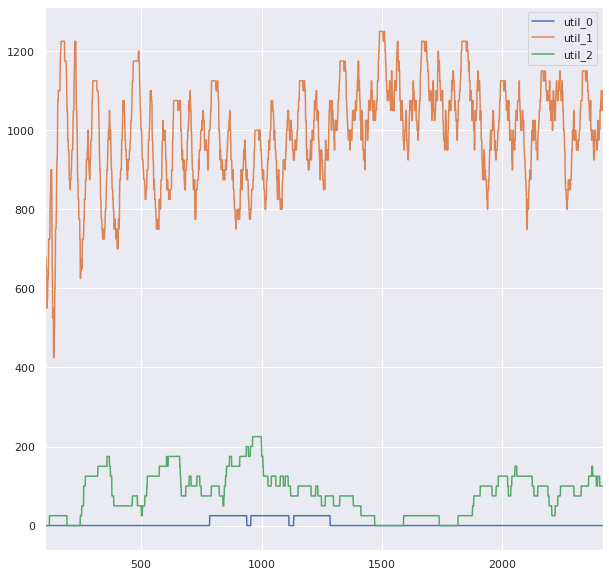

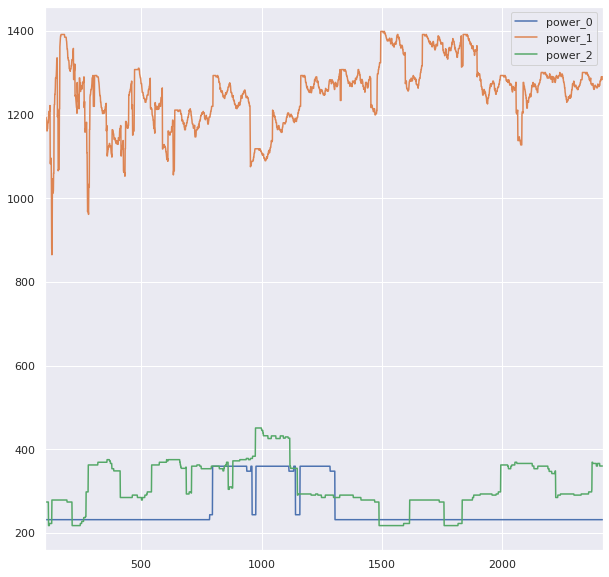

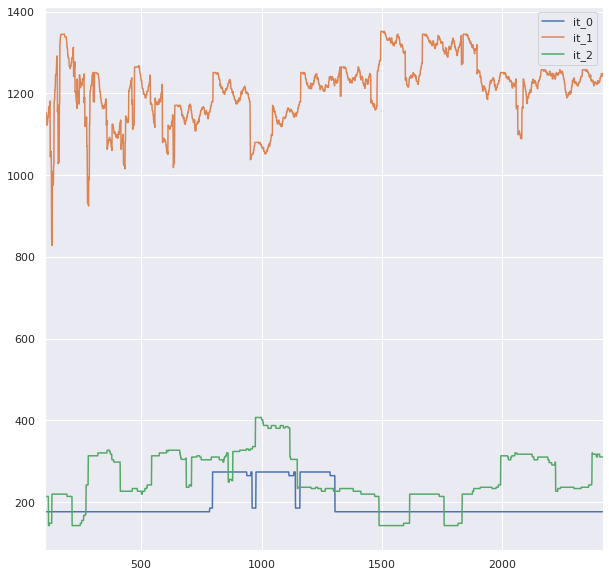

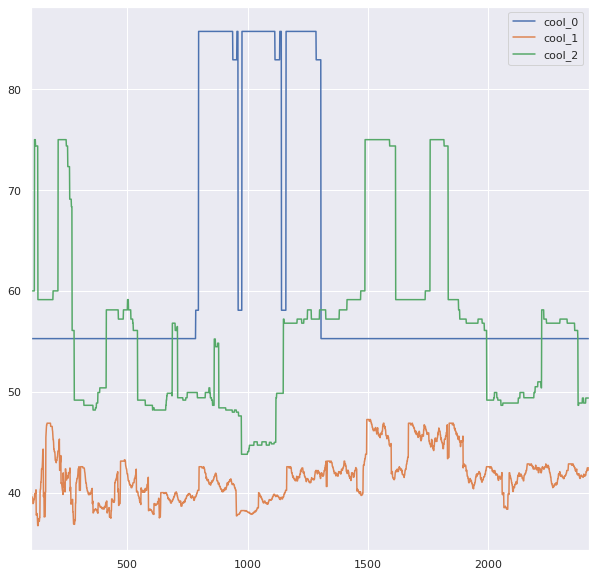

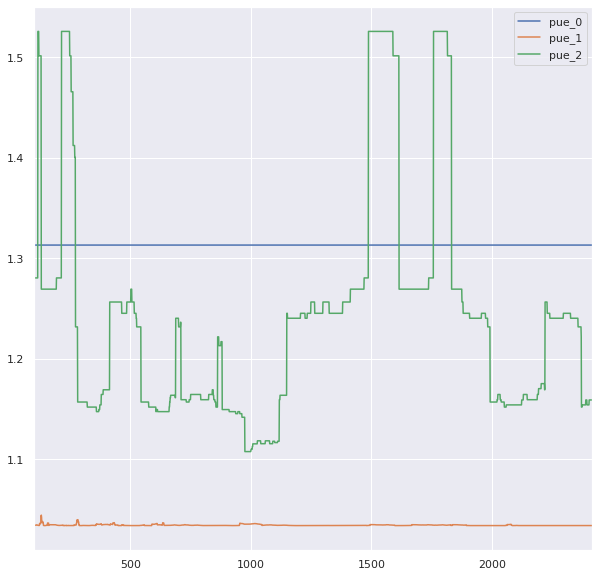

In [407]:
for col in ["util", "power", "it", "cool","pue"]:
    scaled_df.iloc[100:].plot(y=[col+"_0", col+"_1", col+"_2"], figsize=(10,10))

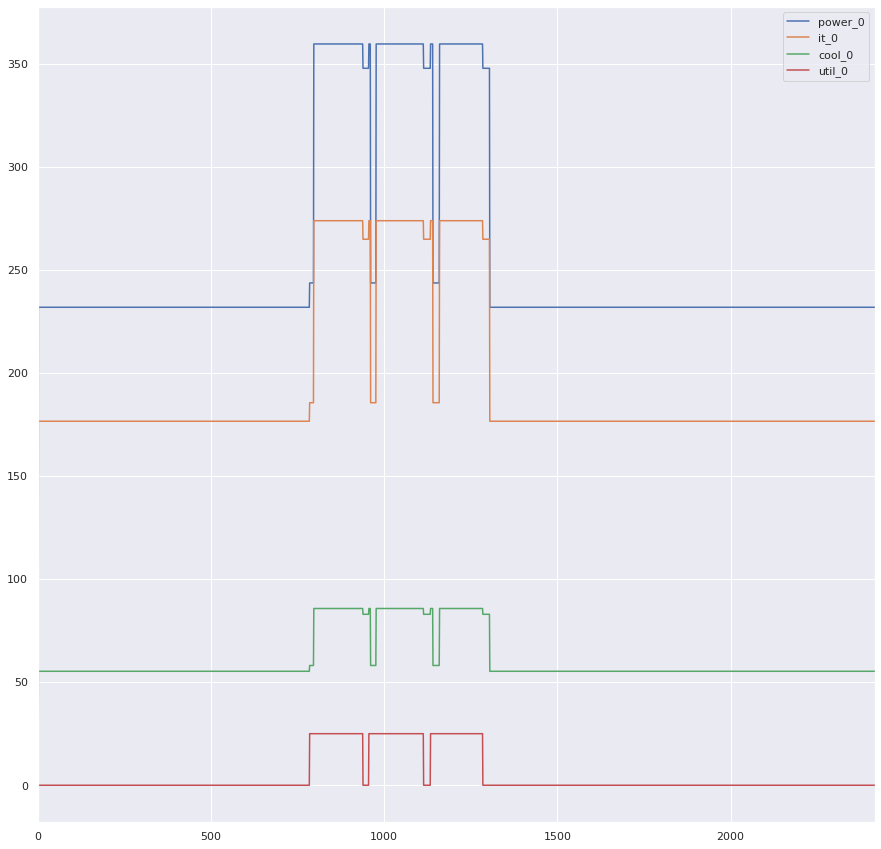

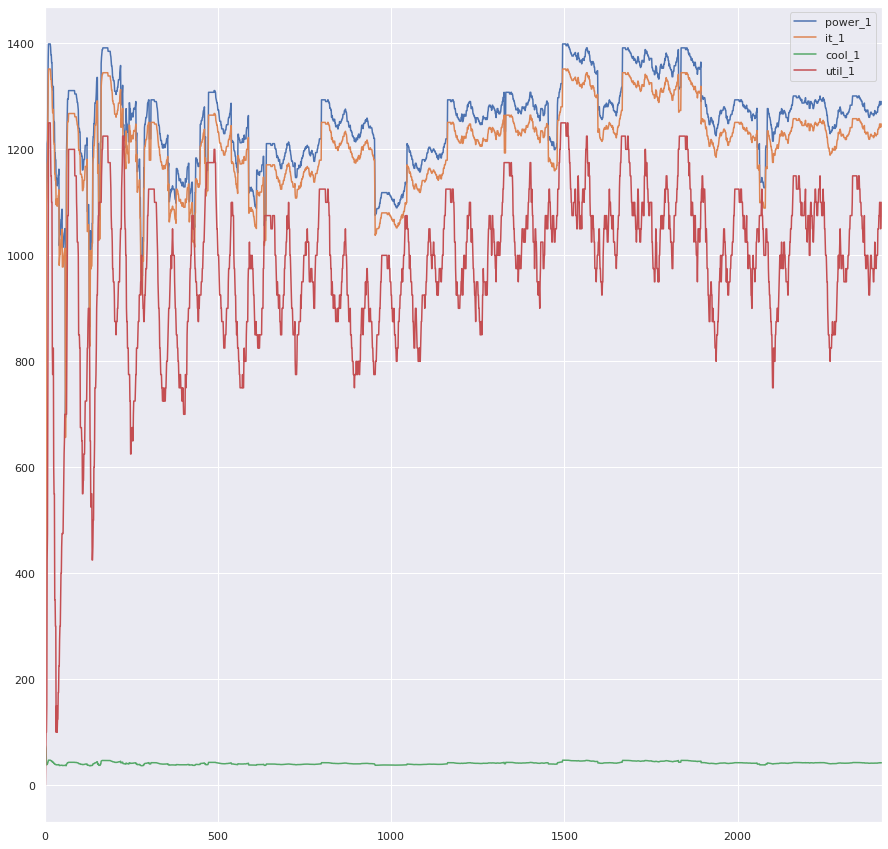

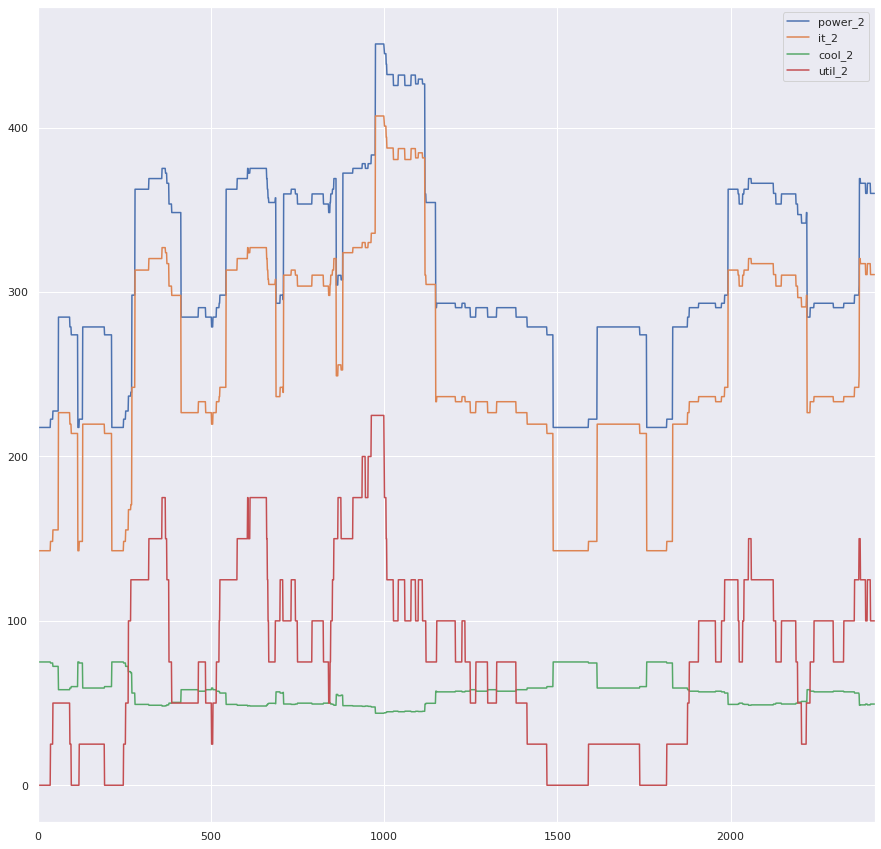

In [408]:
for i in range(3):
    scaled_df.plot(y=["power_"+str(i),"it_"+str(i),"cool_"+str(i),"util_"+str(i)], figsize=(15,15))

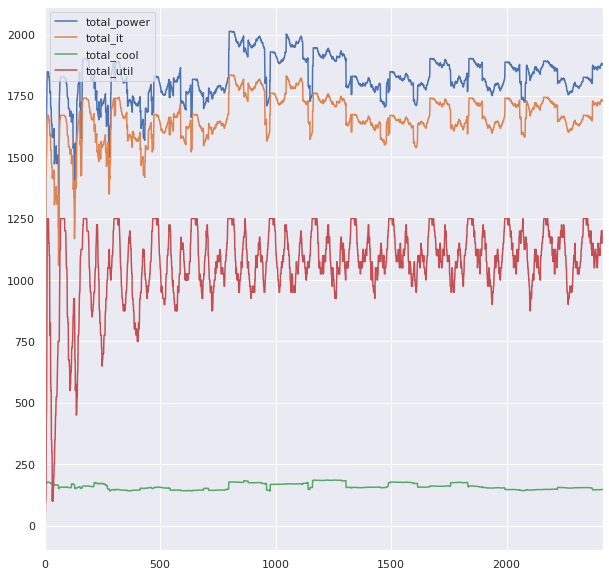

In [409]:
scaled_df["total_power"] = scaled_df["power_0"] + scaled_df["power_1"] + scaled_df["power_2"]
scaled_df["total_it"] = scaled_df["it_0"] + scaled_df["it_1"] + scaled_df["it_2"]
scaled_df["total_cool"] = scaled_df["cool_0"] + scaled_df["cool_1"] + scaled_df["cool_2"]
scaled_df["total_util"] = scaled_df["util_0"] + scaled_df["util_1"] + scaled_df["util_2"]
scaled_df.plot(y=[col for col in scaled_df.columns if "total" in col], figsize=(10,10))
plt.show()

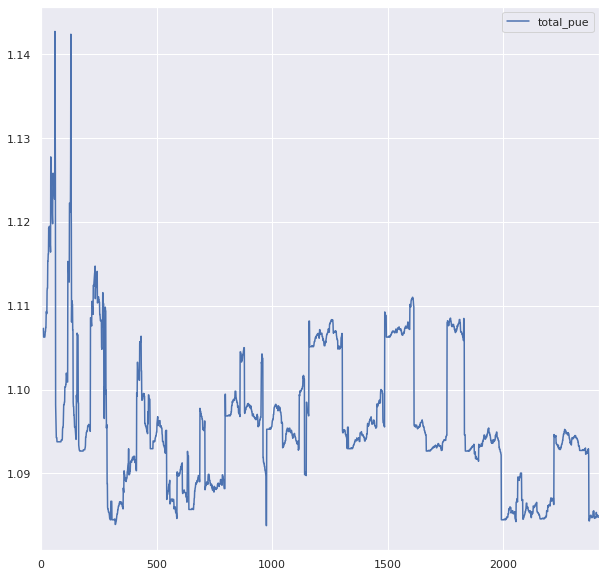

In [410]:
scaled_df["total_pue"] = scaled_df["total_power"].iloc[10:]  / scaled_df["total_it"].iloc[10:]
scaled_df.plot(y="total_pue", figsize=(10,10))
plt.show()

In [411]:
scaled_df.iloc[10:].describe()

,util_0,power_0,it_0,cool_0,util_1,power_1,it_1,cool_1,util_2,power_2,it_2,cool_2,pue_0,pue_1,pue_2,total_power,total_it,total_cool,total_util,total_pue
count,2.407000e+03,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2.407000e+03,2407.000000,2407.000000,2407.000000,2.407000e+03,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000
mean,4.808891e+00,256.884166,195.633769,61.250398,988.668467,1252.269183,1210.641293,41.627890,7.888450e+01,312.636994,256.295614,56.341381,1.313087e+00,1.034418,1.247065,1821.790343,1662.570676,159.219669,1072.361862,1.095942
std,9.855820e+00,50.136554,38.182201,11.954352,148.368878,81.783194,79.499775,2.393391,5.358580e+01,57.247195,65.356793,8.505780,1.522086e-10,0.000952,0.116490,91.973209,87.485851,12.592282,148.645866,0.008120
min,3.516609e-07,231.835379,176.557511,55.277869,100.000000,694.032332,656.227356,36.743351,3.516609e-07,217.676453,142.676453,43.813093,1.313087e+00,1.033980,1.107604,1210.670288,1059.461229,140.134611,100.000001,1.083770
25%,3.516609e-07,231.835379,176.557511,55.277869,925.000000,1204.481099,1164.626350,39.854749,2.500000e+01,278.816530,219.674736,49.180780,1.313087e+00,1.034001,1.156916,1776.786280,1622.363293,147.485705,1025.000001,1.090341
50%,3.516609e-07,231.835379,176.557511,55.277869,1000.000000,1265.998455,1224.393814,41.604642,7.500000e+01,293.230139,236.423218,56.806921,1.313087e+00,1.034111,1.240276,1817.928953,1661.124650,155.626467,1075.000000,1.094490
75%,3.516609e-07,231.835379,176.557511,55.277869,1075.000000,1293.467115,1250.889152,42.577964,1.250000e+02,362.602281,313.421502,59.141794,1.313087e+00,1.034584,1.269224,1885.451568,1724.944962,170.257494,1175.000000,1.099219
max,2.500000e+01,359.552989,273.822663,85.730327,1250.000000,1398.896211,1351.637542,47.258670,2.250000e+02,450.981359,407.168267,75.000001,1.313087e+00,1.057610,1.525665,2012.768272,1835.045144,185.282842,1250.000000,1.142723



# REWARD, Q-VALUES, ETC. INFO

In [359]:
!ls ../info/

dist.txt	     vanilla_a3c_training_info.txt
mercury_info_parsed  vanilla_a3c_training_results.csv
train_arrays.txt


In [360]:
df_2 = pd.read_csv('../info/train_arrays.txt',
                   delimiter=",",
                   names=["log_prob", "_", "reward", "v_vals",
                          "q_vals", "entropy"])
df_2 = df_2.drop(["_"], axis=1)
df_2["log_prob"] = df_2["log_prob"].apply(lambda x: x.split("(")[1])
df_2["log_prob"] = df_2["log_prob"].astype("float64")



df_2["a_vals"] = df_2.q_vals - df_2.v_vals

df_2

,log_prob,reward,v_vals,q_vals,entropy,a_vals
0,-0.6469,-986.932678,-0.299426,5.944760,1.020330,6.244186
1,-1.5227,-1018.159668,-0.295007,5.863042,1.023624,6.158049
2,-1.5126,-1028.317627,-0.293902,5.788065,1.024829,6.081967
3,-0.6653,-1033.615479,-0.286571,5.714793,1.027809,6.001364
4,-0.6703,-1033.615479,-0.283989,5.642063,1.030150,5.926052
...,...,...,...,...,...,...
141310,-0.0734,-1617.467529,-0.292182,0.054991,0.300357,0.347173
141311,-0.0734,-1617.467529,-0.292182,0.072221,0.300357,0.364403
141312,-0.0727,-1619.233398,-0.297337,0.089624,0.298025,0.386961
141313,-0.0727,-1619.233398,-0.297337,0.107358,0.298025,0.404695


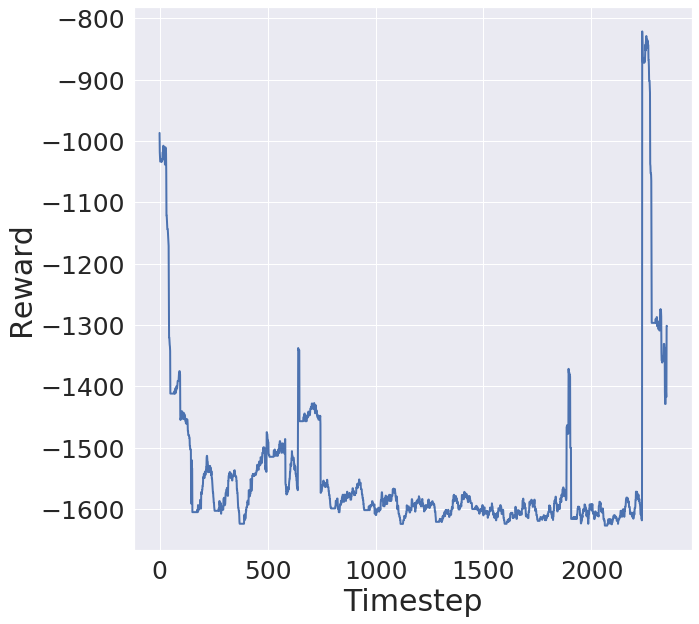

In [361]:

GAMMA = 0.0
rew = df_2.reward.iloc[:2350].values
#rew = (rew - np.mean(rew)) / (np.std(rew) + 0.00000000000000000001)
q_val = rew[-1]
q_vals = np.zeros_like(rew)

for i in reversed(range(len(rew))):
    q_val_temp = q_val
    q_val = rew[i] + GAMMA * q_val
    q_vals[i] = q_val
#q_vals = (q_vals - np.mean(q_vals)) / (np.std(q_vals) + 0.00000000000000000001)

plt.figure(figsize=(10,10))
plt.plot(q_vals, linewidth=2)
plt.ylabel("Reward", fontsize=30)
plt.xlabel('Timestep', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#plt.legend(fontsize=25)
plt.show()


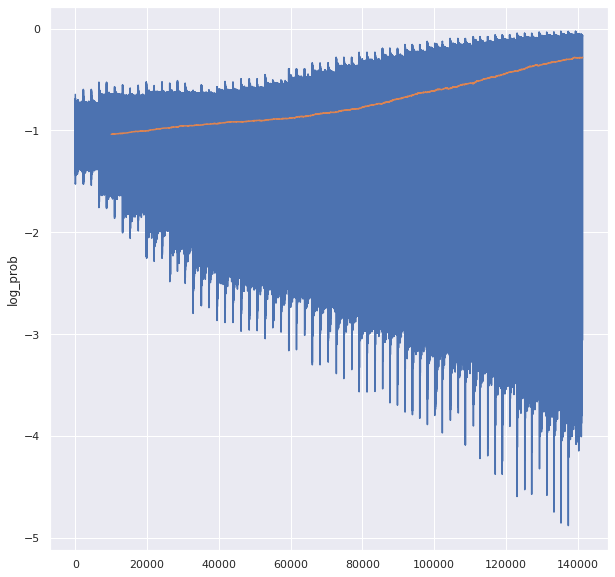

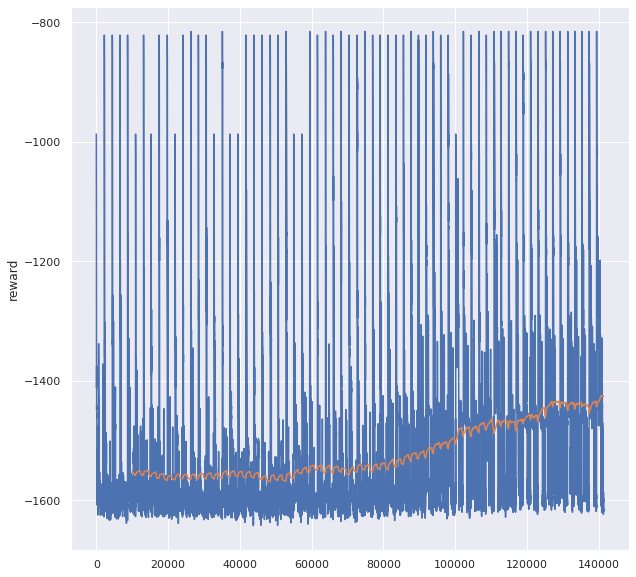

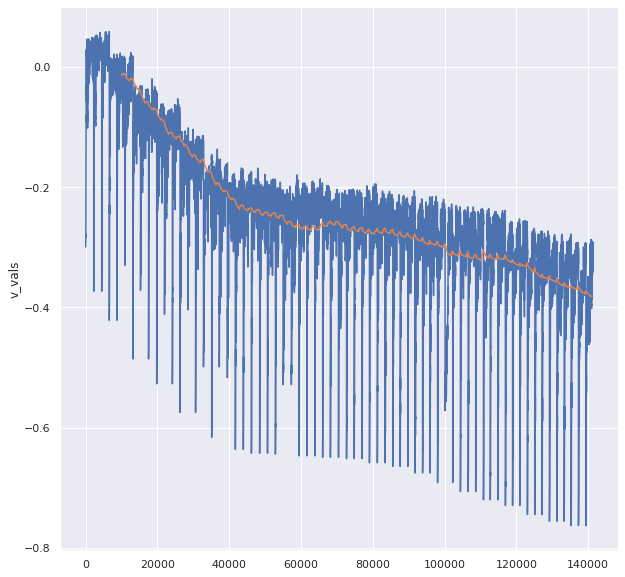

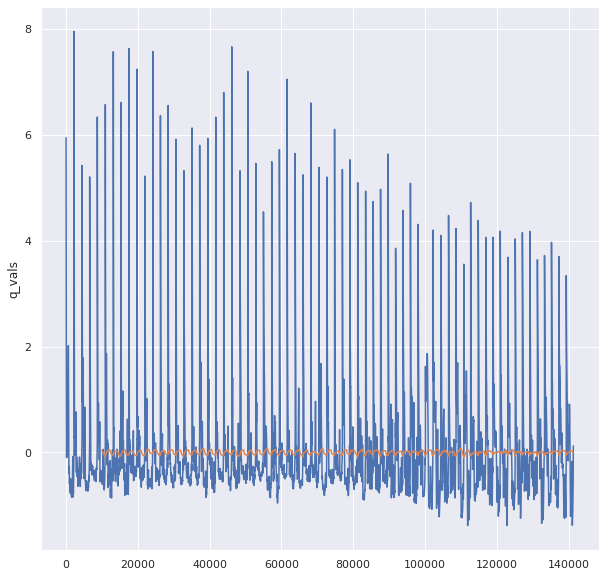

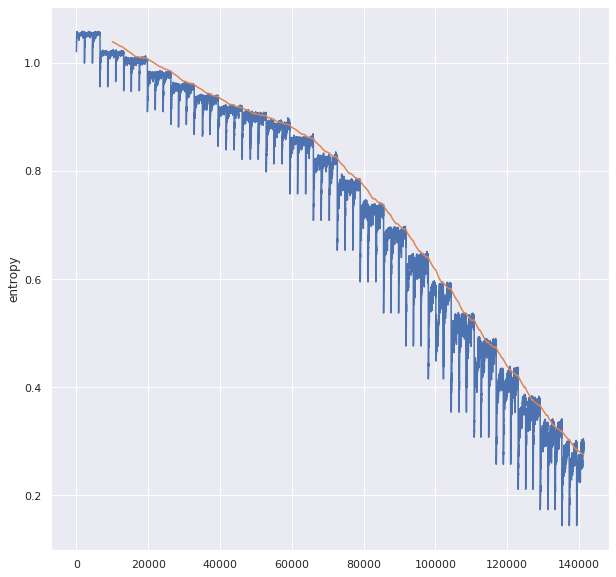

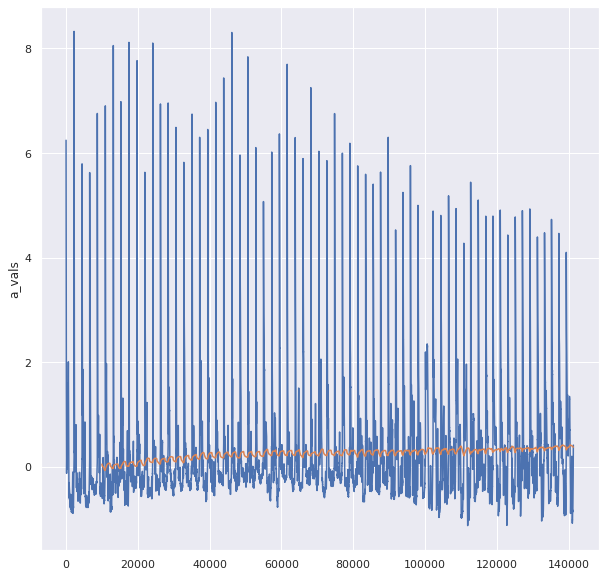

In [362]:
for col in df_2.columns:
    plt.figure(figsize=(10,10))
    plt.plot(df_2[col])
    plt.plot(pd.Series.rolling(pd.Series(df_2[col]), 10000).mean())
    plt.ylabel(col)
    plt.show()

# DISTRIBUTION INFO

In [412]:
df_3 = pd.read_csv('../info/dist.txt', delimiter=",", names=["dist"])
df_3["edc_0"] = df_3.dist.apply(lambda x: list(filter(lambda a: a is not "", x.split(" ")))[0][1:])
df_3["edc_1"] = df_3.dist.apply(lambda x: list(filter(lambda a: a is not "", x.split(" ")))[1])
df_3["edc_2"] = df_3.dist.apply(lambda x: list(filter(lambda a: a is not "", x.split(" ")))[2][:-1])

df_3.edc_0 = df_3.edc_0.astype("float64")
df_3.edc_1 = df_3.edc_1.astype("float64")
df_3.edc_2 = df_3.edc_2.astype("float64")

df_3 = df_3.drop(["dist"], axis=1)

df_3

,edc_0,edc_1,edc_2
0,0.254150,0.465572,0.280278
1,0.263014,0.461556,0.275429
2,0.264410,0.460912,0.274678
3,0.265652,0.462807,0.271541
4,0.259329,0.474244,0.266426
...,...,...,...
199860,0.000662,0.869539,0.129799
199861,0.000645,0.868671,0.130684
199862,0.000655,0.869254,0.130092
199863,0.000647,0.868927,0.130426


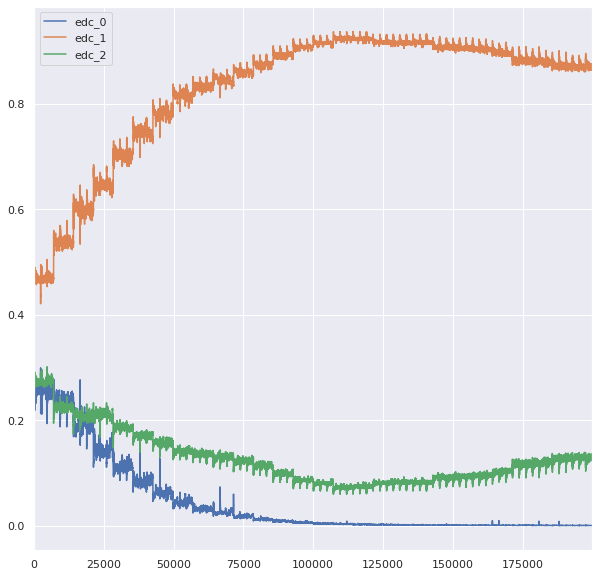

In [413]:
df_3.iloc[:].plot(y=["edc_0","edc_1","edc_2"], figsize=(10,10))

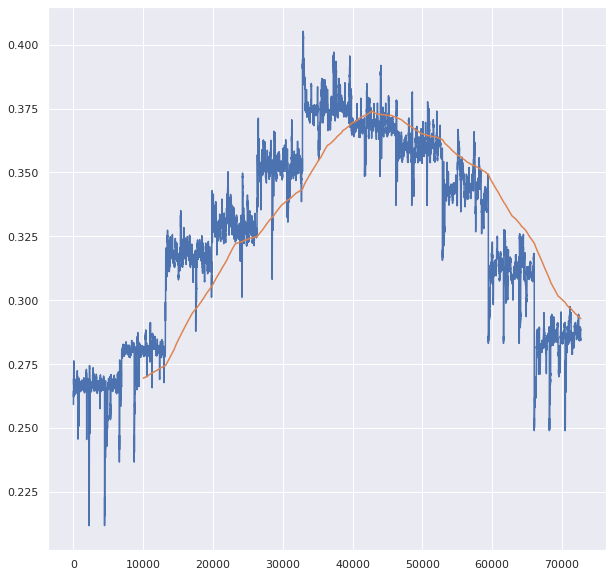

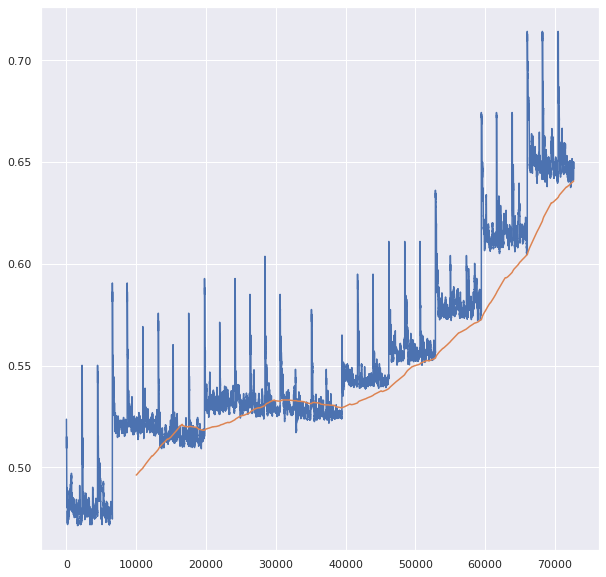

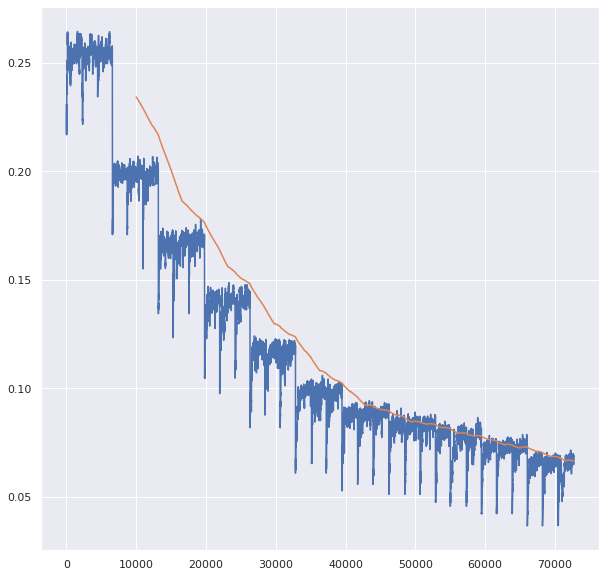

In [315]:
for col in df_3.columns:
    plt.figure(figsize=(10,10))
    plt.plot(df_3[col])
    plt.plot(pd.Series.rolling(pd.Series(df_3[col]), 10000).mean())
plt.show()


# REWARD COMPUTATION

In [103]:
"""  
### OPTION 1 ### no scale

if penalty[i]:
    reward = -AVAILABILITY_PENALTY
else:
    power_consumption = x[i+1, 1::2]
    reward = -np.sum(np.power(power_consumption, 3))

### OPTION 2 ### scale  

if penalty[i]:
    reward = -AVAILABILITY_PENALTY
else:
    utilization = x[i+1, 0::2]
    power_consumption = x[i+1, 1::2]
    reward = -np.sum(np.power(power_consumption/(utilization+1), 1))
if reward<-AVAILABILITY_PENALTY:
    reward = -AVAILABILITY_PENALTY

### OPTION 3 ### no scale, penalty = 0.5
wrong for positive numbers, although it always gives negative number with standard
not intended scaling for (-1,1) range using pow 3 -> not relevant for rewards around 50-100 but still "wrong"

power_consumption = x[i+1, 1::2]
total_power = np.sum(np.power(power_consumption, 3))
pen = penalty[i]
reward = - (1 - AVAILABILITY_PENALTY * pen) * total_power

### OPTION 4 ### scale, penalty= 1,10,20

offset = np.sum(np.mean(x[:, 1::2], axis=0))/x[:, 1::2].shape[1]

power_consumption = x[i+1, 1::2] - offset
total_power = np.power(np.sum(power_consumption), 1)
pen = penalty[i]
if total_power > 0:
    reward = - (1 + AVAILABILITY_PENALTY * pen) * total_power
else:
    reward = - (1 - AVAILABILITY_PENALTY * pen) * total_power
"""
print()

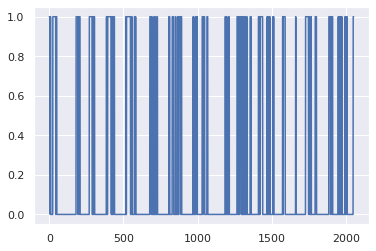

(2053, 12)


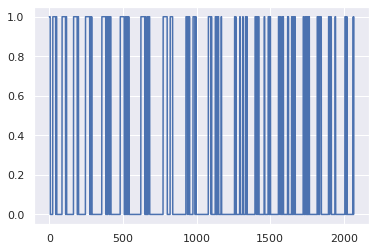

(2067, 12)


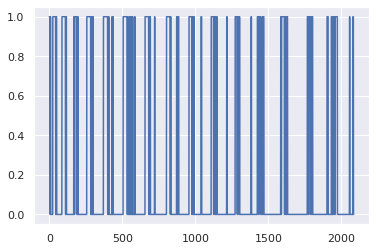

(2085, 12)
3 2066


In [354]:
EPSILON = np.finfo(np.float32).eps
AVAILABILITY_PENALTY = 0

rewards = []
#directory = "../results/vanilla_a3c_v2_lite_env_6_UE_50_GPUperEDC_10_standarize_data&Qvalues_reward_sumrealPOP1P2adam_1e3_ep_30_penalty_1_neurons_128/a3c/"
#directory = "../data/a3c/"
directory = path + "/a3c/"


for filename in sorted(os.listdir(directory)):
    
    tmp_cols = COLUMN_NAMES
    
    df_tmp = pd.read_csv(os.path.join(directory, filename), delimiter=";", names=tmp_cols).iloc[6:]
    
    
    x = df_tmp[COLUMN_NAMES[:-2]].values
    penalty = df_tmp["penalty"].values
    
    
    scale_pair = scale_dict[scale_mode][scale_factor]["util"]
    x[:,0::4] = inverse_scale_data(x[:, 0::4])

    scale_pair = scale_dict[scale_mode][scale_factor]["power"]
    x[:,1::4] = inverse_scale_data(x[:, 1::4])
    
    """
    offset = inverse_scale_data(offset)
    offset = np.sum(np.mean(x[:, 1::5], axis=0))/x[:, 1::5].shape[1]
    print(offset)
    """

    plt.plot(penalty)
    plt.show()
    
    
    ep_rewards = []
    print(x.shape)
    
    for i in range(len(x)-1):
        
        power_consumption = x[i+1, 1::4] # total power
        total_power = np.power(np.sum(power_consumption), 1)
        pen = penalty[i]
        if total_power > 0:
            reward = - (1 + AVAILABILITY_PENALTY * pen) * total_power
        else:
            reward = - (1 - AVAILABILITY_PENALTY * pen) * total_power
        
        ep_rewards.append(reward)
    rewards.append(ep_rewards)

print(len(rewards), len(rewards[1]))

In [355]:
df_tmp.columns[:-2]

Index(['util_0', 'power_0', 'it_0', 'cool_0', 'util_1', 'power_1', 'it_1',
       'cool_1', 'util_2', 'power_2', 'it_2', 'cool_2'],
      dtype='object')

mean reward 0: -1310.5316328777844
mean reward 1: -1332.467400836283
mean reward 2: -1312.156626779958


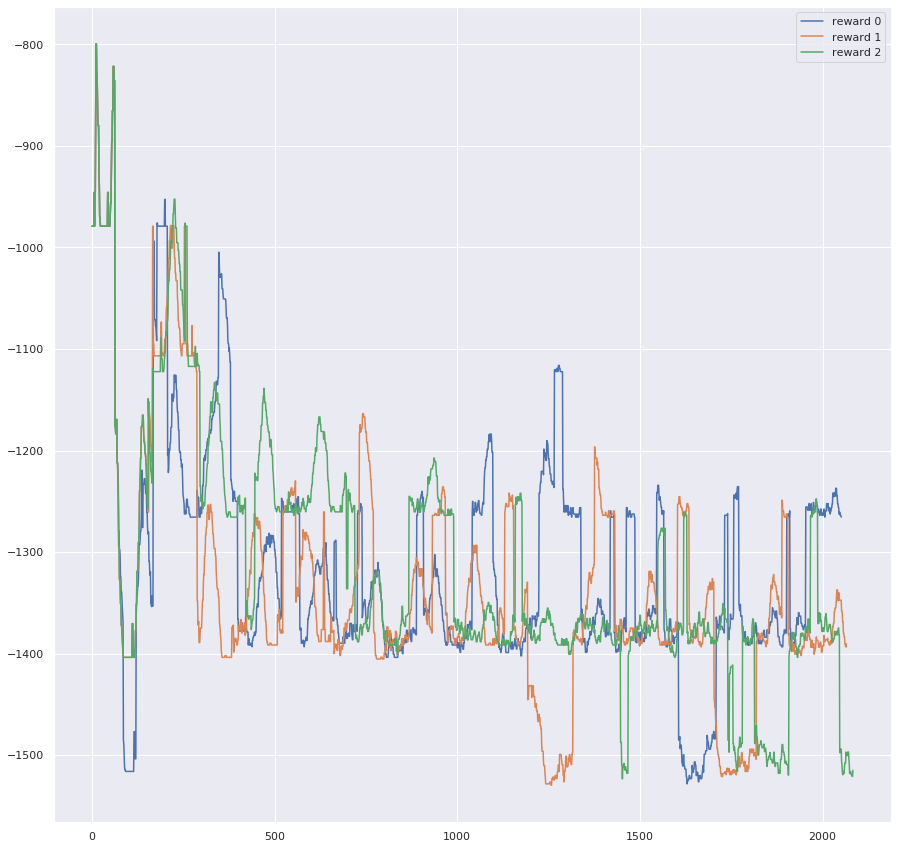

In [356]:
plt.figure(figsize=(15,15))
for i in range(len(rewards)):
    print("mean reward {}: {}".format(i, sum(rewards[i])/len(rewards[i])))
    plt.plot(rewards[i][:])
plt.legend(["reward "+str(i) for i in range(len(rewards))])
plt.show()

# Episodes: Loss, Mean Reward, etc.

In [34]:
! ls ../info

dist.txt	     vanilla_a3c_training_info.txt
mercury_info_parsed  vanilla_a3c_training_results.csv
train_arrays.txt


In [212]:
df_4 = pd.read_csv('../info/vanilla_a3c_training_results.csv',
                   delimiter=";",
                   names=["episodes", "length", "rewards", "loss", "entropies"])
df_4

,episodes,length,rewards,loss,entropies
0,0,7037,-1.032953e+07,0.942357,-0.001096
1,1,7126,-1.037373e+07,1.072444,-0.001084
2,2,6920,-9.884721e+06,1.186764,-0.001067
3,3,6970,-9.967450e+06,1.244947,-0.001050
4,4,6693,-9.623154e+06,1.353065,-0.001022
5,5,6874,-9.781734e+06,1.399506,-0.001001
6,6,7072,-1.008291e+07,1.455343,-0.000978
7,7,6945,-9.927228e+06,1.500673,-0.000955
8,8,6833,-9.595213e+06,1.540871,-0.000930
9,9,6744,-9.510155e+06,1.589237,-0.000894


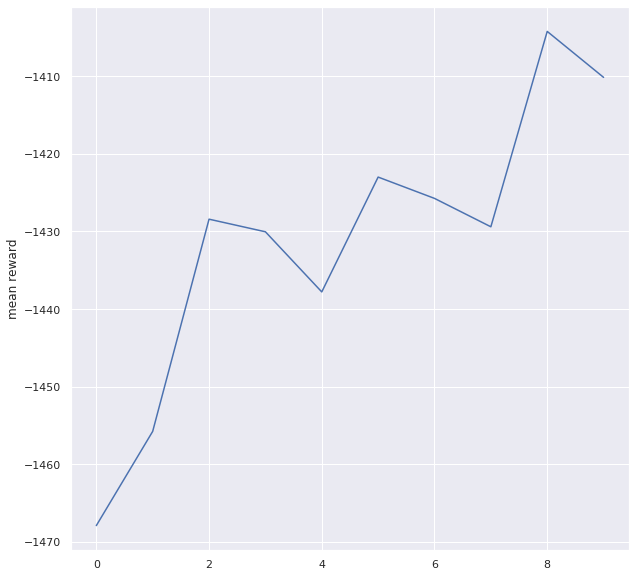

In [213]:
plt.figure(figsize=(10,10))
plt.plot(df_4["rewards"]/df_4["length"])
plt.plot(pd.Series.rolling(pd.Series(df_4["rewards"]/df_4["length"]), 10).mean())
plt.ylabel("mean reward")
plt.show()

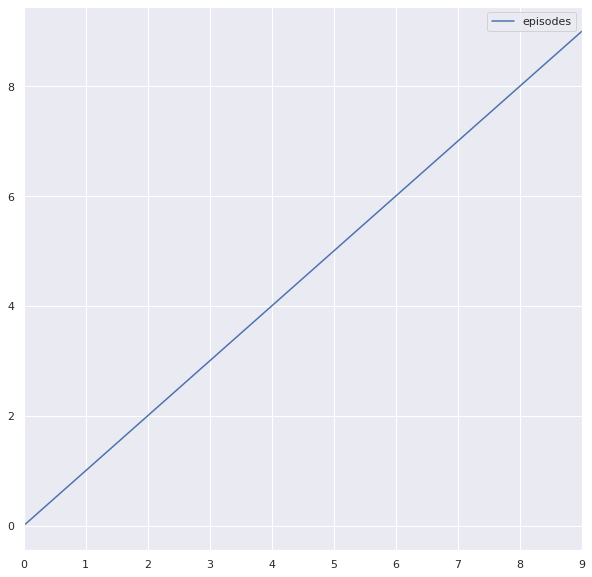

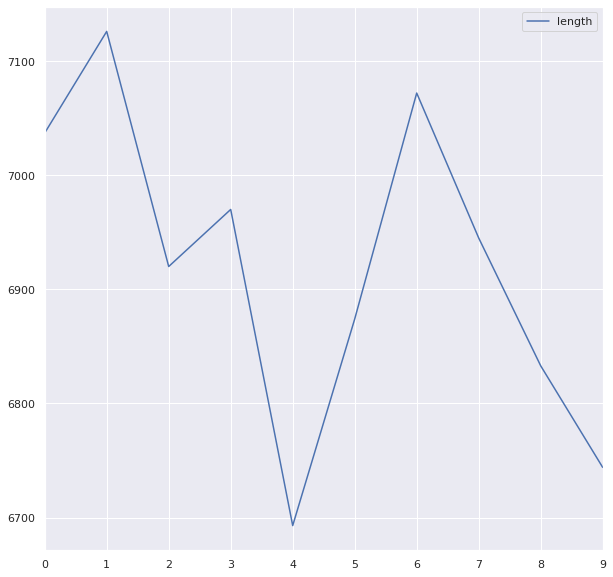

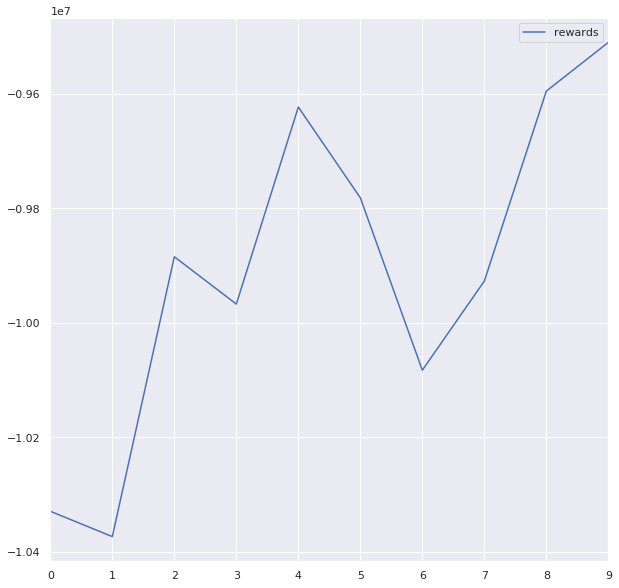

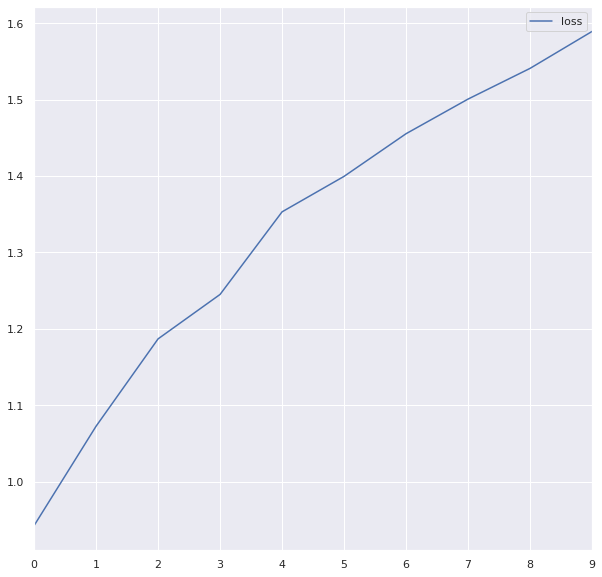

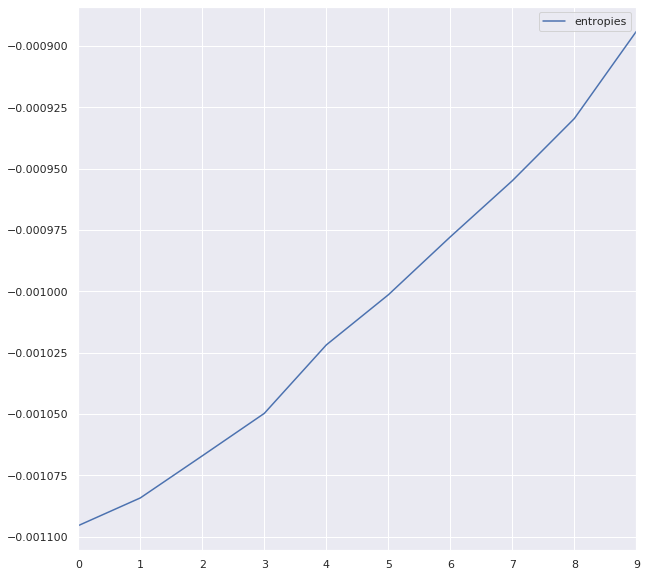

In [214]:
for col in df_4.columns:
    df_4.plot(y=col, figsize=(10,10))

# Episodes (2nd Option)

### Training info file must be cleaned before!! (remove lines with no commas)

In [96]:
df_5 = pd.read_csv('../info/vanilla_a3c_training_info.txt',
                   delimiter=",",
                   names=["episodes", "time", "length", "mean rewards", "loss"])

def compute_loss(x):
    losses = x.split(":")[1].split(" ")
    return sum([float(l) for l in losses[1:]])

for col in df_5.columns[:-1]:
    df_5[col] = df_5[col].str.split(":").str[1].astype(np.float)
df_5["entropy"] =  df_5["loss"].str.split(":").str[1].str.split(" ").str[3].astype(np.float)
df_5["loss"] =  df_5["loss"].apply(compute_loss)
df_5

AttributeError: 'float' object has no attribute 'split'

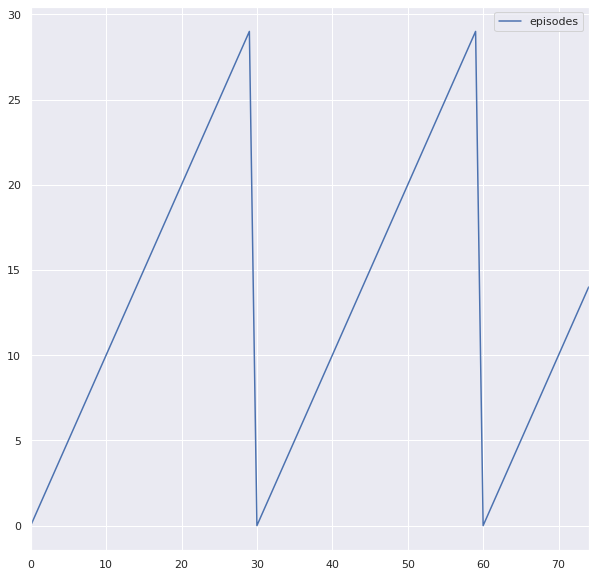

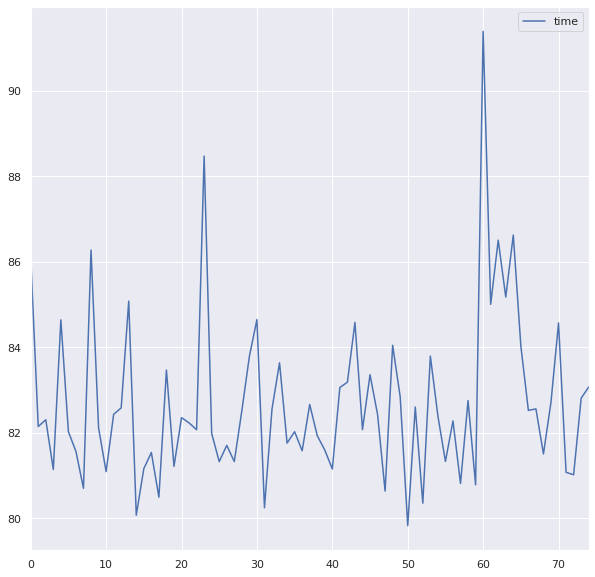

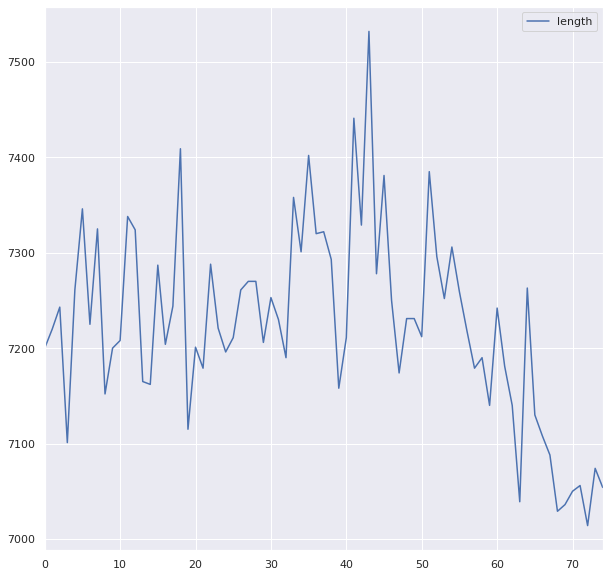

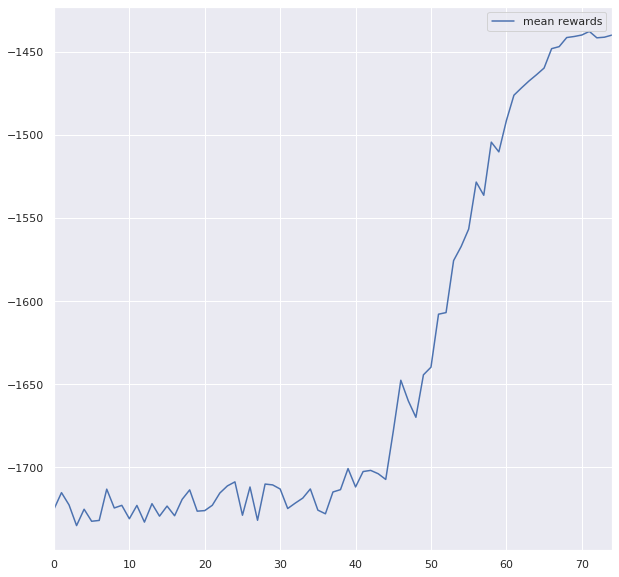

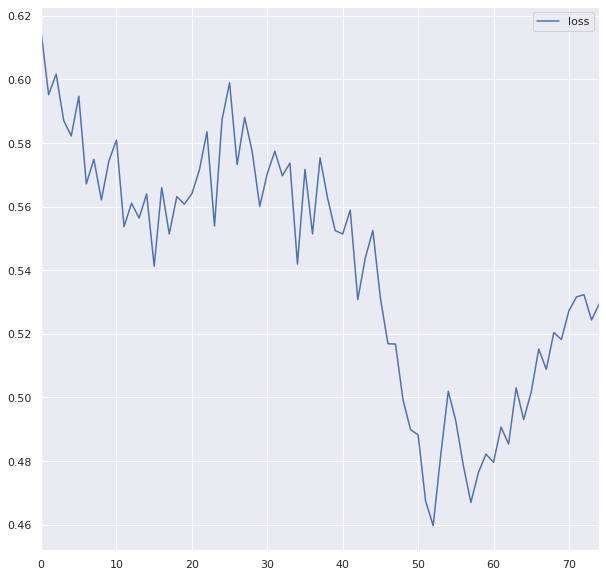

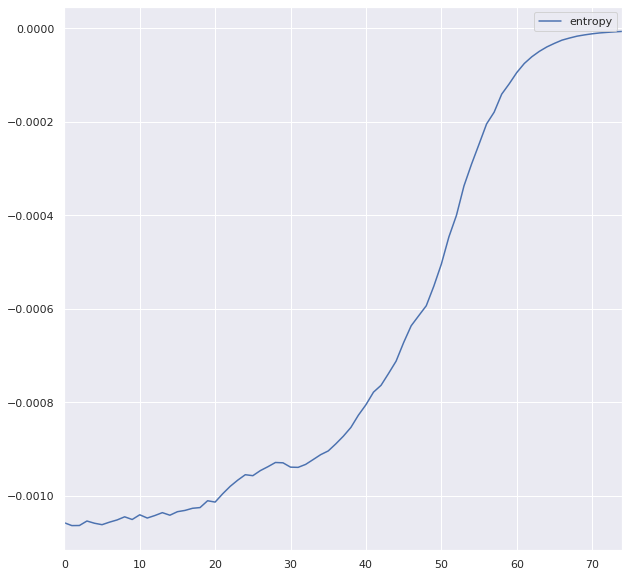

In [77]:
for col in df_5.columns:
    df_5.plot(y=col, figsize=(10,10))

# Extra

In [347]:
xxxx

array([-1000.,  -999.,  -998., ...,   998.,   999.,  1000.])

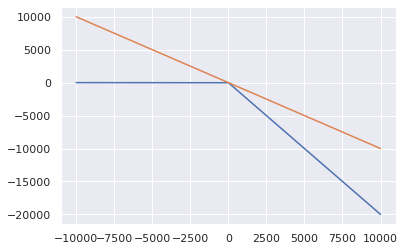

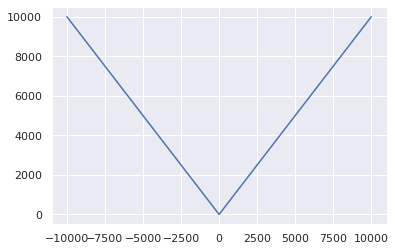

In [550]:
xxxx = np.linspace(-10000,10000, num=20001)
yyyy = []
AVAILABILITY_PENALTY = 1
for xxx in xxxx:
    if xxx > 0:
        yyy = - (1 + AVAILABILITY_PENALTY) * xxx
    else:
        yyy = - (1 - AVAILABILITY_PENALTY) * xxx
            
    yyyy.append(yyy)

plt.plot(xxxx, yyyy)
plt.plot(xxxx, -xxxx)
plt.show()
plt.plot(xxxx, -xxxx-yyyy)
plt.show()
